# Step 3 Calculating interaction of randomly generated particles in 3D space

In [1]:
import numpy as np
from scipy.special import lpmn, factorial
from fast_multipole_method import Vlm
from fast_multipole_method import operation as op

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('ggplot')
def plot_3d(x):
    """plot particles in 3 dimentional"""
    y = np.transpose(x)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(y[0], y[1], y[2])
    ax = ax.view_init(30)
    plt.show()
    return 

In [3]:
#case 3.1 construction: random particles
num_particles = 100
x_i = np.ndarray(shape=(3, num_particles))
x_i[0] = 20 * np.random.rand(num_particles) - 10
x_i[1] = 20 * np.random.rand(num_particles) - 10
x_i[2] = 20 * np.random.rand(num_particles) - 10
x_i = np.transpose(x_i)
q = np.ones(num_particles)

In [4]:
#case 3.2 construction: nearly uniform distributed particles:
num_particles_in_a_box = 1
num_particels_1D = 4
num_particles = num_particles_in_a_box * num_particels_1D **3
X = np.zeros(shape=(num_particles,3))

for i in range(0,num_particels_1D):
    for j in range(0,num_particels_1D):
        for k in range(0,num_particels_1D):
            X[i*num_particels_1D*num_particels_1D+j*num_particels_1D+k] = [i,j,k] 

q = np.ones(num_particles)

In [5]:
[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(X)

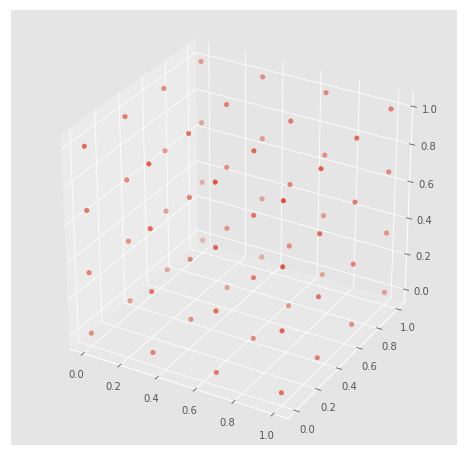

In [6]:
plot_3d(x0_i)

In [7]:
scale_factor

array([0.        , 3.00000003])

In [8]:
(min(x_i.transpose()[0]) - scale_factor[0])/ scale_factor[1]

-3.2936729808323273

import timeit

start = timeit.default_timer()

[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(x_i)

stop = timeit.default_timer()

print(stop - start) 

In [9]:
# analytical answer
pair_potential = np.zeros(shape=(num_particles,num_particles)) 
for i in range(0, num_particles):
    for j in range(i+1, num_particles):
        pair_potential[i][j] = 1 / (op.distance_cal(x0_i[i], x0_i[j]) * scale_factor[1])
        
pair_potential

array([[0.        , 1.        , 0.5       , ..., 0.22941573, 0.21320072,
        0.19245009],
       [0.        , 0.        , 1.        , ..., 0.23570226, 0.22941573,
        0.21320072],
       [0.        , 0.        , 0.        , ..., 0.22941573, 0.23570226,
        0.22941573],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [10]:
J_analytic = np.zeros(num_particles)
for i in range(0, num_particles):
    for j in range(0, num_particles):
        if j<i:
            J_analytic[i] += pair_potential[j][i]
        if j>i:
            J_analytic[i] += pair_potential[i][j]

J_analytic

array([23.48061413, 26.36770548, 26.36770548, 23.48061413, 26.36770548,
       29.89095014, 29.89095014, 26.36770548, 26.36770548, 29.89095014,
       29.89095014, 26.36770548, 23.48061413, 26.36770548, 26.36770548,
       23.48061413, 26.36770548, 29.89095014, 29.89095014, 26.36770548,
       29.89095014, 34.21896147, 34.21896147, 29.89095014, 29.89095014,
       34.21896147, 34.21896147, 29.89095014, 26.36770548, 29.89095014,
       29.89095014, 26.36770548, 26.36770548, 29.89095014, 29.89095014,
       26.36770548, 29.89095014, 34.21896147, 34.21896147, 29.89095014,
       29.89095014, 34.21896147, 34.21896147, 29.89095014, 26.36770548,
       29.89095014, 29.89095014, 26.36770548, 23.48061413, 26.36770548,
       26.36770548, 23.48061413, 26.36770548, 29.89095014, 29.89095014,
       26.36770548, 26.36770548, 29.89095014, 29.89095014, 26.36770548,
       23.48061413, 26.36770548, 26.36770548, 23.48061413])

In [11]:
total_energy = 0.5 * sum(J_analytic)
total_energy

905.9021698539976

In [12]:
from fast_multipole_method import fmm_level as fl
from fast_multipole_method import fmm_q_source as fq

In [13]:
# build list of q_source
q_source = np.ndarray(shape=(len(x0_i)), dtype=fq) 
for i in range(0, len(x0_i)):
    q_source[i] = fq(x0_i[i], q[i])

In [20]:
# run the calculation:
#1 construction of boxes at each level with Olm
btm_level = 3
p = 5
ws_index = 2
f_btm_level = fl(btm_level, q_source, p, ws_index)

f_level_i = f_btm_level
while (f_level_i.num_boxes_1d * 2 - 2 >=  ws_index):
    print(f_level_i.level)
    f_level_i = f_level_i.parent_level_construction()
    
#2 calculation the interaction and translation the potential
print('----------')
J_far_field = None
while (J_far_field != None):
    f_level_i = f_level_i.higher_level
    print(f_level_i.level)
    f_level_i.box_interactions()
    J_far_field = f_level_i.interaction_with_child_level()
    


3
2
1


ValueError: invalid literal for int() with base 2: ''

In [19]:
f_level_i.higher_level

AttributeError: 'fmm_level' object has no attribute 'higher_level'

In [17]:
J_far_field /= scale_factor[1]

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [ ]:
#4 calculation of J near filed
J_near_field = np.zeros(num_particles)
for i in range(0,num_particles):
    J_near_field[i] = 0.
    for j in f_btm_level.box_list[q_source[i].box_id].q_source_id_set:
        if j == i:
            continue
        J_near_field[i] += 1  / (op.distance_cal(q_source[i].x, q_source[j].x) * scale_factor[1])
    for NN_box_id in f_btm_level.box_list[q_source[i].box_id].NN_box_id_set:
        for j in f_btm_level.box_list[NN_box_id].q_source_id_set:
            J_near_field[i] += 1  / (op.distance_cal(q_source[i].x, q_source[j].x) * scale_factor[1])

In [ ]:
J_near_field

In [ ]:
J_total = J_far_field + J_near_field
J_total

In [ ]:
total_energy = 0.5 * sum(J_total)
total_energy

In [ ]:
J_error = np.abs(J_total-J_analytic) / J_analytic
J_error

In [ ]:
J_error[1:50]

In [ ]:
x = np.array([1,2,3])